This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# 4. Getting started with neural networks: Classification and regression
1. [Binary Classification: IMDB Reviews](#binclas)
1. [Multiclass Classification: Newswires](#multiclass)
1. [Regression: House Prices](#regression)

<a name='binclas'></a>
## 4.1 Classifying movie reviews: A binary classification example

<a name="data"></a>
### The IMDB dataset

**Loading the IMDB dataset**

In [39]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The variables `train_data` and `test_data` are __lists of reviews__; each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where `0` stands for __negative__ and `1` stands for __positive__.

In [40]:
print(train_data[0], "\n")
print(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 

1


**Decoding reviews back to text**

In [41]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_review[:100]

"? this film was just brilliant casting location scenery story direction everyone's really suited the"

<a name="preparing"></a>
### Preparing the data

You can’t directly feed lists of integers into a NN. They all have different lengths, but __a NN expects to process contiguous batches of data__. You have to __turn your lists into tensors__. There are 2 ways to do that:

1. __Pad your lists__ so that they all have the same length, turn them into an integer tensor of shape `(samples, max_length)`, and start your model with a layer capable of handling such integer tensors.

2. __Multi-hot encode your lists__ to turn them into vectors of 0s and 1s. Then you could use a `Dense` layer, capable of handling floating-point vector data, as the first layer in your model.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for maximum clarity.

**Encoding the integer sequences via multi-hot encoding**

In [42]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [43]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [44]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [45]:
# vectorize labels
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

<a name="building"></a>
### Building your model

The __input data is vectors__, and the __labels are scalars__ (1s and 0s): this is one of the simplest problem setups you’ll ever encounter. A type of model that performs well on such a problem is a __plain stack of `Dense` layers with `relu` activations__.

There are two __key architecture decisions__ to be made about such a stack of Dense layers:

1. How many layers to use
2. How many units to choose for each layer

For now: 
1. Two intermediate layers with 16 units each
2. A third layer that will output the scalar prediction regarding the sentiment of the current review

<img src="https://drek4537l1klr.cloudfront.net/chollet2/HighResolutionFigures/figure_4-1.png" style="width:20%;"/>

**Model definition**

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

Each `Dense` layer with a `relu` activation implements the following chain of tensor operations: <br>

`output = relu(dot(input, W) + b)`

* `16` units means the weight matrix $W$ will have shape `(input dim, 16)`
* `relu` zeros out negative values
* `sigmoid` squashes arbitrary values into `0` and `1`, outputs probability.

**Compiling the model**

__Binary classification__ and __probability__ as output:
* `binary_crossentropy`: __crossentropy__ is usually best when dealing with probabilities
* `rmsprop`: usually a good default choice for virtually any problem

In [48]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [9]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

**Training your model**

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 10s 285ms/step - loss: 0.5344 - accuracy: 0.7723 - val_loss: 0.4196 - val_accuracy: 0.8406
Epoch 2/20
30/30 [==============================] - 2s 58ms/step - loss: 0.3235 - accuracy: 0.8959 - val_loss: 0.3151 - val_accuracy: 0.8843
Epoch 3/20
30/30 [==============================] - 1s 40ms/step - loss: 0.2343 - accuracy: 0.9249 - val_loss: 0.3338 - val_accuracy: 0.8645
Epoch 4/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1865 - accuracy: 0.9405 - val_loss: 0.2719 - val_accuracy: 0.8905
Epoch 5/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1517 - accuracy: 0.9520 - val_loss: 0.2745 - val_accuracy: 0.8889
Epoch 6/20
30/30 [==============================] - 1s 38ms/step - loss: 0.1270 - accuracy: 0.9583 - val_loss: 0.3029 - val_accuracy: 0.8836
Epoch 7/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1057 - accuracy: 0.9692 - val_loss: 0.2981 - val_accuracy: 0.8850
Epoch 8/20


The call `model.fit()` returns a `History` object which has a member `history` (a dict containing data about everything that happened during training).

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Plotting the training and validation loss**

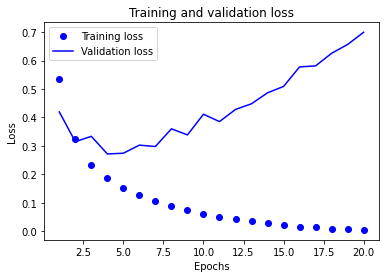

In [12]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

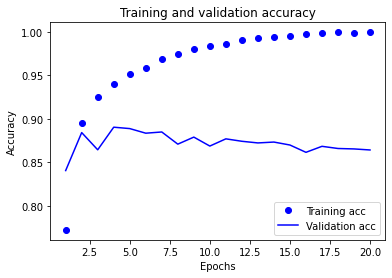

In [13]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [14]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 2s 17ms/step - loss: 0.4563 - accuracy: 0.8339
Epoch 2/4
49/49 [==============================] - 1s 16ms/step - loss: 0.2604 - accuracy: 0.9110
Epoch 3/4
49/49 [==============================] - 1s 15ms/step - loss: 0.1995 - accuracy: 0.9290
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2924 - accuracy: 0.8837


In [15]:
results

[0.2924253046512604, 0.883679986000061]

### Using a trained model to generate predictions on new data

In [16]:
model.predict(x_test)

array([[0.22093278],
       [0.99976367],
       [0.9383265 ],
       ...,
       [0.16458312],
       [0.08418083],
       [0.6915604 ]], dtype=float32)

### Further experiments

1. __More representation layers__.

In [17]:
# build model
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    # adding an extra Dense layer
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 12s 365ms/step - loss: 0.5104 - accuracy: 0.7931 - val_loss: 0.4028 - val_accuracy: 0.8480
Epoch 2/5
30/30 [==============================] - 2s 76ms/step - loss: 0.2925 - accuracy: 0.9028 - val_loss: 0.3322 - val_accuracy: 0.8632
Epoch 3/5
30/30 [==============================] - 1s 37ms/step - loss: 0.2066 - accuracy: 0.9295 - val_loss: 0.2777 - val_accuracy: 0.8880
Epoch 4/5
30/30 [==============================] - 1s 34ms/step - loss: 0.1639 - accuracy: 0.9429 - val_loss: 0.2795 - val_accuracy: 0.8885
Epoch 5/5
30/30 [==============================] - 1s 32ms/step - loss: 0.1275 - accuracy: 0.9587 - val_loss: 0.2948 - val_accuracy: 0.8866


2. __Less representation layers__.

In [18]:
# build model
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    # removing a Dense layer
    #layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 8s 205ms/step - loss: 0.5053 - accuracy: 0.7855 - val_loss: 0.3896 - val_accuracy: 0.8692
Epoch 2/5
30/30 [==============================] - 1s 27ms/step - loss: 0.3168 - accuracy: 0.9027 - val_loss: 0.3211 - val_accuracy: 0.8832
Epoch 3/5
30/30 [==============================] - 1s 26ms/step - loss: 0.2447 - accuracy: 0.9252 - val_loss: 0.2972 - val_accuracy: 0.8852
Epoch 4/5
30/30 [==============================] - 1s 26ms/step - loss: 0.2023 - accuracy: 0.9362 - val_loss: 0.2825 - val_accuracy: 0.8886
Epoch 5/5
30/30 [==============================] - 1s 25ms/step - loss: 0.1704 - accuracy: 0.9497 - val_loss: 0.2731 - val_accuracy: 0.8885


3. Layers with __more units__.

In [19]:
# build model
model = keras.Sequential([
    # increasing units
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 6s 149ms/step - loss: 0.4822 - accuracy: 0.7876 - val_loss: 0.3536 - val_accuracy: 0.8632
Epoch 2/5
30/30 [==============================] - 1s 27ms/step - loss: 0.2667 - accuracy: 0.9051 - val_loss: 0.3175 - val_accuracy: 0.8700
Epoch 3/5
30/30 [==============================] - 1s 28ms/step - loss: 0.1978 - accuracy: 0.9296 - val_loss: 0.2780 - val_accuracy: 0.8885
Epoch 4/5
30/30 [==============================] - 1s 25ms/step - loss: 0.1465 - accuracy: 0.9499 - val_loss: 0.3905 - val_accuracy: 0.8521
Epoch 5/5
30/30 [==============================] - 1s 25ms/step - loss: 0.1209 - accuracy: 0.9594 - val_loss: 0.3047 - val_accuracy: 0.8839


4. Layers with __less units__.

In [20]:
# build model
model = keras.Sequential([
    # decreasing units
    layers.Dense(8, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 5s 145ms/step - loss: 0.5315 - accuracy: 0.7888 - val_loss: 0.4160 - val_accuracy: 0.8698
Epoch 2/5
30/30 [==============================] - 1s 25ms/step - loss: 0.3402 - accuracy: 0.8967 - val_loss: 0.3342 - val_accuracy: 0.8812
Epoch 3/5
30/30 [==============================] - 1s 24ms/step - loss: 0.2544 - accuracy: 0.9213 - val_loss: 0.2937 - val_accuracy: 0.8894
Epoch 4/5
30/30 [==============================] - 1s 25ms/step - loss: 0.2029 - accuracy: 0.9357 - val_loss: 0.2768 - val_accuracy: 0.8922
Epoch 5/5
30/30 [==============================] - 1s 22ms/step - loss: 0.1653 - accuracy: 0.9499 - val_loss: 0.2978 - val_accuracy: 0.8809


5. __Changing loss function__ from `binary_crossentropy` to `mse`.

In [21]:
# build model
model = keras.Sequential([
    
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              # changing loss function
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 11s 358ms/step - loss: 0.5362 - accuracy: 0.7853 - val_loss: 0.4135 - val_accuracy: 0.8603
Epoch 2/5
30/30 [==============================] - 1s 27ms/step - loss: 0.3311 - accuracy: 0.8967 - val_loss: 0.3219 - val_accuracy: 0.8802
Epoch 3/5
30/30 [==============================] - 1s 25ms/step - loss: 0.2407 - accuracy: 0.9224 - val_loss: 0.2859 - val_accuracy: 0.8886
Epoch 4/5
30/30 [==============================] - 1s 24ms/step - loss: 0.1899 - accuracy: 0.9363 - val_loss: 0.2811 - val_accuracy: 0.8869
Epoch 5/5
30/30 [==============================] - 1s 26ms/step - loss: 0.1534 - accuracy: 0.9500 - val_loss: 0.2818 - val_accuracy: 0.8857


5. __Changing activation function__ from `relu` to `tanh`.

In [22]:
# build model
model = keras.Sequential([
    # chaning activation function
    layers.Dense(16, activation="tanh"),
    layers.Dense(16, activation="tanh"),
    layers.Dense(1, activation="sigmoid")
])

# compile model
model.compile(optimizer="rmsprop",
              # changing loss function
              loss="binary_crossentropy",
              metrics=["accuracy"])

# train model
model.fit(partial_x_train, partial_y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 5s 137ms/step - loss: 0.4787 - accuracy: 0.8018 - val_loss: 0.3540 - val_accuracy: 0.8771
Epoch 2/5
30/30 [==============================] - 1s 27ms/step - loss: 0.2764 - accuracy: 0.9071 - val_loss: 0.2898 - val_accuracy: 0.8854
Epoch 3/5
30/30 [==============================] - 1s 29ms/step - loss: 0.1916 - accuracy: 0.9386 - val_loss: 0.2809 - val_accuracy: 0.8850
Epoch 4/5
30/30 [==============================] - 1s 29ms/step - loss: 0.1478 - accuracy: 0.9514 - val_loss: 0.2895 - val_accuracy: 0.8835
Epoch 5/5
30/30 [==============================] - 1s 26ms/step - loss: 0.1120 - accuracy: 0.9635 - val_loss: 0.3326 - val_accuracy: 0.8746


### Wrapping up

* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options too.
* Stacks of `Dense` layers with relu activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.
* In a binary classification problem (two output classes), your model should end with a `Dense` layer with one unit and a `sigmoid` activation: the output of your model should be a scalar between `0` and `1`, encoding a probability.
* With such a scalar `sigmoid` output on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set.

<a name='multiclass'></a>
## 4.2. Classifying newswires: A multiclass classification example

In this section, we’ll build a model to classify Reuters newswires into `46`__mutually exclusive topics__. 

Because we have many classes and each data point should be classified into only one category, this problem is an instance of __single-label multiclass classification__.

### The Reuters dataset

**Loading the Reuters dataset**

In [63]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [64]:
len(train_data)

8982

In [65]:
len(test_data)

2246

In [66]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


**Decoding newswires back to text**

In [67]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

decoded_newswire[:100]

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987'

In [68]:
train_labels[:10]

array([ 3,  4,  3,  4,  4,  4,  4,  3,  3, 16], dtype=int64)

### Preparing the data

**Encoding the input data**

In [69]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To __vectorize the labels__, there are two possibilities: 
1. you can cast the label list as an __integer tensor__.
1. you can use __one-hot encoding__.

**Encoding the labels**

In [70]:
from tensorflow.keras.utils import to_categorical

# one-hot encode labels
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

In a stack of `Dense` layers like those we’ve been using, each layer can only access information present in the output of the previous layer. 

If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an __information bottleneck__. 

In the previous example, we used `16`-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information.

**Model definition**

In [71]:
x_train.shape

(8982, 10000)

In [72]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

#model.summary()

**Compiling the model**

In [73]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [74]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Training the model**

In [75]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 62ms/step - loss: 2.6391 - accuracy: 0.5341 - val_loss: 1.7169 - val_accuracy: 0.6350
Epoch 2/20
16/16 [==============================] - 1s 38ms/step - loss: 1.3950 - accuracy: 0.7071 - val_loss: 1.3028 - val_accuracy: 0.7200
Epoch 3/20
16/16 [==============================] - 1s 41ms/step - loss: 1.0340 - accuracy: 0.7765 - val_loss: 1.1280 - val_accuracy: 0.7540
Epoch 4/20
16/16 [==============================] - 1s 35ms/step - loss: 0.8160 - accuracy: 0.8285 - val_loss: 1.0639 - val_accuracy: 0.7730
Epoch 5/20
16/16 [==============================] - 1s 32ms/step - loss: 0.6572 - accuracy: 0.8623 - val_loss: 0.9759 - val_accuracy: 0.8020
Epoch 6/20
16/16 [==============================] - 0s 31ms/step - loss: 0.5203 - accuracy: 0.8928 - val_loss: 0.9266 - val_accuracy: 0.8060
Epoch 7/20
16/16 [==============================] - 1s 33ms/step - loss: 0.4222 - accuracy: 0.9127 - val_loss: 0.9106 - val_accuracy: 0.8140
Epoch 8/20
16

**Plotting the training and validation loss**

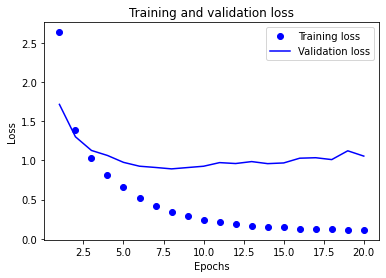

In [76]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

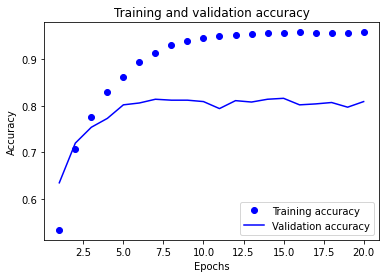

In [77]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [78]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 31ms/step - loss: 2.5759 - accuracy: 0.5225
Epoch 2/9
18/18 [==============================] - 1s 30ms/step - loss: 1.4280 - accuracy: 0.7042
Epoch 3/9
18/18 [==============================] - 0s 27ms/step - loss: 1.0583 - accuracy: 0.7742
Epoch 4/9
18/18 [==============================] - 0s 27ms/step - loss: 0.8327 - accuracy: 0.8219
Epoch 5/9
18/18 [==============================] - 0s 26ms/step - loss: 0.6633 - accuracy: 0.8612
Epoch 6/9
18/18 [==============================] - 0s 27ms/step - loss: 0.5324 - accuracy: 0.8900
Epoch 7/9
18/18 [==============================] - 1s 31ms/step - loss: 0.4328 - accuracy: 0.9122
Epoch 8/9
18/18 [==============================] - 1s 29ms/step - loss: 0.3497 - accuracy: 0.9266
Epoch 9/9
71/71 [==============================] - 0s 2ms/step - loss: 0.9526 - accuracy: 0.7956


In [79]:
results

[0.9525944590568542, 0.7956367135047913]

This approach reaches an accuracy of ~80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. 

But in this case, we have 46 classes, and they may not be equally represented. What would be the __accuracy of a random baseline__?

In [81]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.1803205699020481

### Generating predictions on new data

In [82]:
predictions = model.predict(x_test)

In [83]:
predictions[0].shape

(46,)

In [84]:
np.sum(predictions[0])

0.9999999

In [85]:
np.argmax(predictions[0])

3

### A different way to handle the labels and the loss

We mentioned earlier that another way to __encode the labels would be to cast them as an integer tensor__.

In [86]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The loss function used in listing 4.21, `categorical_crossentropy`, expects the labels to follow a categorical encoding. With integer labels, you should use `sparse_categorical_ crossentropy`.

This new loss function is still __mathematically the same as `categorical_crossentropy`__; it just has a different interface.

In [88]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

We mentioned earlier that because the final outputs are `46-dimensional`, you should avoid intermediate layers with many fewer than 46 units. 

Now let’s see what happens when we introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, `4-dimensional`.

**A model with an information bottleneck**

In [89]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 20ms/step - loss: 3.0884 - accuracy: 0.3882 - val_loss: 2.3775 - val_accuracy: 0.4350
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 1.8632 - accuracy: 0.6019 - val_loss: 1.6176 - val_accuracy: 0.6250
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 1.3940 - accuracy: 0.6680 - val_loss: 1.4387 - val_accuracy: 0.6490
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 1.2161 - accuracy: 0.6853 - val_loss: 1.3608 - val_accuracy: 0.6600
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0879 - accuracy: 0.7008 - val_loss: 1.3111 - val_accuracy: 0.6830
Epoch 6/20
63/63 [==============================] - 1s 16ms/step - loss: 0.9756 - accuracy: 0.7226 - val_loss: 1.2918 - val_accuracy: 0.6850
Epoch 7/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8720 - accuracy: 0.7645 - val_loss: 1.2740 - val_accuracy: 0.7140
Epoch 8/20
63

The model now peaks at ~71% validation accuracy, an 8% absolute drop. 

This drop is mostly due to the fact that __we’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional__. 

The model is able to cram most of the necessary information into these four-dimensional representations, but not all of it.

### Wrapping up

* If you’re trying to classify data points among `N` classes, your model should end with a `Dense` layer of size `N`.
* In a single-label, multiclass classification problem, your model should end with a `softmax` activation so that it will output a probability distribution over the `N` output classes.
* `Categorical crossentropy` is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the model and the true distribution of the targets.
* There are two ways to handle labels in multiclass classification:
    * Encoding the labels via __categorical encoding__ (also known as one-hot encoding) and using `categorical_crossentropy` as a loss function
    * __Encoding the labels as integers__ and using the `sparse_categorical_crossentropy` loss function
* If you need to classify data into a large number of categories, you should avoid creating __information bottlenecks__ in your model due to intermediate layers that are too small.

<a name='regression'></a>
## 3. Predicting house prices: A regression example

### The Boston Housing Price dataset

The dataset we’ll use has an interesting difference from the two previous examples. It has __relatively few data points__: only `506`, split between `404 training samples` and `102 test samples`. 

And __each feature in the input data has a different scale__. For instance, some values are proportions, which take values between __0 and 1__, others take values between __1 and 12__, others between __0 and 100__, and so on.

**Loading the Boston housing dataset**

In [90]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 1us/step


In [91]:
train_data.shape

(404, 13)

In [92]:
test_data.shape

(102, 13)

In [95]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. 

A widespread best practice for dealing with such data is to do __feature-wise normalization__: for each feature in the input data, we subtract the mean of the feature and divide by the standard deviation, so that the feature is __centered around 0 and has a unit standard deviation__. This is easily done in NumPy.

**Normalizing the data**

In [97]:
# calculate mean & std on training data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

# subtract mean from each value
train_data -= mean
test_data -= mean

# divide each value with std
train_data /= std
test_data /= std

Note that __the quantities used for normalizing the test data are computed using the `training data`__. You should never use any quantity computed on the test data in your workflow, even for something as simple as data normalization.

### Building your model

Because so few samples are available, we’ll use a very small model with two intermediate layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and __using a small model is one way to mitigate overfitting__.

**Model definition**

In [98]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

The model ends with a __single unit and no activation__ (it will be a linear layer). This is a typical setup for scalar regression. 

Applying an activation function would constrain the range the output can take; for instance, if you applied a `sigmoid` activation function to the last layer, the model could only learn to predict values between 0 and 1. 

Here, because the last layer is purely linear, the model is free to learn to predict values in any range

### Validating your approach using K-fold validation

To evaluate our model while we keep adjusting its parameters (such as the number of `epochs` used for training), we could split the data into a `training set` and a `validation set`, as we did in the previous examples. But because we have so few data points, the validation set would end up being very small. 

As a consequence, the validation scores might change a lot depending on which data points we chose for validation and which we chose for training: the validation scores might have a high variance with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use __K-fold cross-validation__.

**K-fold validation**

In [99]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [100]:
all_scores

[1.7987521886825562, 2.339858055114746, 2.4029805660247803, 2.3520166873931885]

In [101]:
np.mean(all_scores)

2.2234018743038177

We’re off by \\$2,220 on average, which is significant considering that the prices range from \\$10,000 to $50,000.

**Saving the validation logs at each fold**

In [102]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [103]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

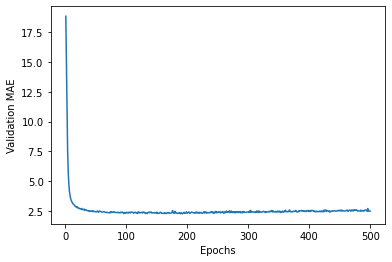

In [104]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot, due to a __scaling issue__: the validation MAE for the first few epochs is dramatically higher than the values that follow. 

Let’s omit the first 10 data points, which are on a different scale than the rest of the curve.

**Plotting validation scores, excluding the first 10 data points**

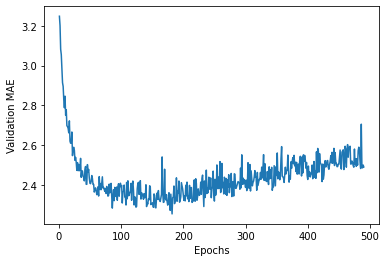

In [105]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the intermediate layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

**Training the final model**

In [106]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 12.6974 - mae: 2.4074


In [107]:
test_mae_score

2.4073543548583984

### Generating predictions on new data

In [108]:
predictions = model.predict(test_data)
predictions[0]

array([7.6138616], dtype=float32)

### Wrapping up

* Regression is done using different loss functions than we used for classification. `Mean squared error` (MSE) is a loss function commonly used for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is `mean absolute error` (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using __K-fold validation__ is a great way to reliably evaluate a model.
* When __little training data__ is available, it’s preferable to use a __small model with few intermediate layers__ (typically only one or two), in order to avoid severe overfitting.